# South Park Dialogues Analysis And Dialogues To Character Prediction

## Introduction

This notebook is a part of project for university class "PRiAD" (Presentation and Analysis of Data). The main goal of this project is to analyze [South Park](https://en.wikipedia.org/wiki/South_Park) dialogues and predict which character said which dialogue. The dataset used in this project is available on Kaggle: https://www.kaggle.com/tovarischsukhov/southparklines. The dataset contains 70896 dialogues from 18 seasons of South Park. The dataset contains the following columns: Season, Episode, Character, Line. The dataset is in CSV format.

## Goals

The main goals of this project are:
- Analyze South Park dialogues and find interesting patterns
- Build a model that predicts which character said which dialogue
- Evaluate the model

## Tools

The following tools will be used in this project:
- Python
- Pandas
- Numpy
- Matplotlib
- Seaborn
- nltk
- re
- WordCloud
- ***And more to come...***

## Libraries and setup

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import nltk
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk import accuracy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\golas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\golas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\golas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Data insides


In [154]:
raw_data = pd.read_csv("data/SouthParkData.csv", encoding="utf-8", header=0)

raw_data.head(10)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."
5,10,1,Chef,Wow!\n
6,10,1,Mrs. Garrison,Chef?? What kind of questions do you think adv...
7,10,1,Chef,What's the meaning of life? Why are we here?\n
8,10,1,Mrs. Garrison,I hope you're making the right choice.\n
9,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...


## Data cleaning and preprocessing

In [155]:
print(f"Null object in data set:\n {raw_data.isnull().sum()}")
print(f"Na object in data set:\n {raw_data.isna().sum()}")

df = raw_data.dropna()

Null object in data set:
 Season       0
Episode      0
Character    0
Line         0
dtype: int64
Na object in data set:
 Season       0
Episode      0
Character    0
Line         0
dtype: int64


The dataset doesnt contain any null or na values.

In [156]:
df["Line"] = df["Line"].str.replace("\n", "")
df.head(5)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away."
1,10,1,Kyle,Going away? For how long?
2,10,1,Stan,Forever.
3,10,1,Chef,I'm sorry boys.
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


The new line character ( '\n' ) can be safely removed from the "Line" column as it will not be useful in the analysis and model building.

In [157]:
df = df[df["Line"].str.strip().astype(bool)]
df = df[df.Season != "Season"]
df = df[df.Episode != "Episode"]
df = df[df.Character != "Character"]

The empty lines are removed from the dataset. And the rows with "Season", "Episode" and "Character" values are removed.

In [158]:
df["Line"] = df["Line"].str.lower()
df["Line"] = df["Line"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df.head(5)

,Season,Episode,Character,Line
0,10,1,Stan,you guys you guys chef is going away
1,10,1,Kyle,going away for how long
2,10,1,Stan,forever
3,10,1,Chef,im sorry boys
4,10,1,Stan,chef said hes been bored so he joining a group...


The "Line" column is converted to lowercase and all punctuation characters are removed from the column.

In [159]:
characters_count = df["Character"].value_counts()
characters_to_remove = characters_count[characters_count < 500].index

df = df[~df["Character"].isin(characters_to_remove)]

characters_to_remove = pd.Series(characters_to_remove)
characters_to_remove

0           Announcer
1             Stephen
2               Craig
3               Clyde
4               Jesus
            ...      
3928      Reenactor 1
3929    Confederate 2
3930    Confederate 1
3931      Army Doctor
3932        Blind Man
Name: Character, Length: 3933, dtype: object

The characters with less than 500 dialogues are removed from the dataset as they cannot be used appropriately in distinguishing the characters.

In [160]:
stop_words = set(stopwords.words("english"))

df_no_stop = df.copy()
df_no_stop["Line"] = df_no_stop["Line"].apply(lambda x: " ".join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
df_no_stop = df_no_stop[df_no_stop["Line"].str.strip().astype(bool)]

df_no_stop.head(5)

,Season,Episode,Character,Line
0,10,1,Stan,guys guys chef going away
1,10,1,Kyle,going away long
2,10,1,Stan,forever
3,10,1,Chef,im sorry boys
4,10,1,Stan,chef said hes bored joining group called super...


In this document we will analize two variants of the dataset. The first one is the original dataset and the second one is the dataset without stop words. The stop words are removed from the "Line" column to reduce dimensionality and improve the quality of the analysis and model.

## Data analysis

Analysis of the preprocessed dataset to find interesting patterns and insights.

In [161]:
df.describe(include="all")

,Season,Episode,Character,Line
count,37429,37429,37429,37429
unique,18,18,16,33098
top,2,7,Cartman,what
freq,3539,2880,9774,416


After brief look at the data, we can see that there are 60800 dialogues in the dataset. The dataset contains 4 columns: Season, Episode, Character, Line. The dataset contains 18 seasons of South Park with the most frequent being season 2 with 5670 dialogues. The dataset contains 710 unique characters. The most frequent character is "Cartman" with 9550 dialogues.

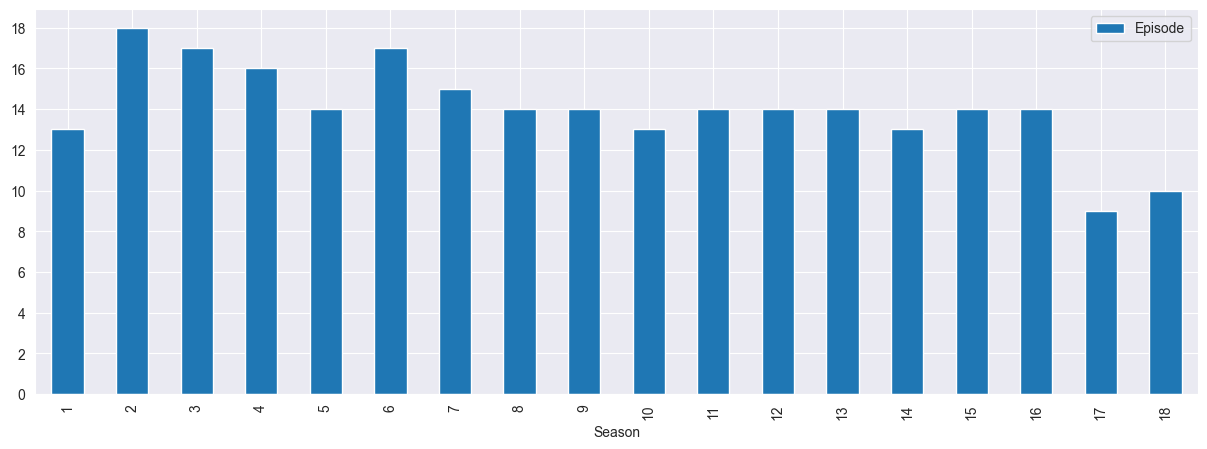

In [162]:
episodes_count = df.groupby("Season")["Episode"].nunique()
episodes_count = episodes_count.sort_index(key=lambda x: x.astype(int)).reset_index()

episodes_count.plot(kind="bar", x="Season", y="Episode", figsize=(15, 5))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

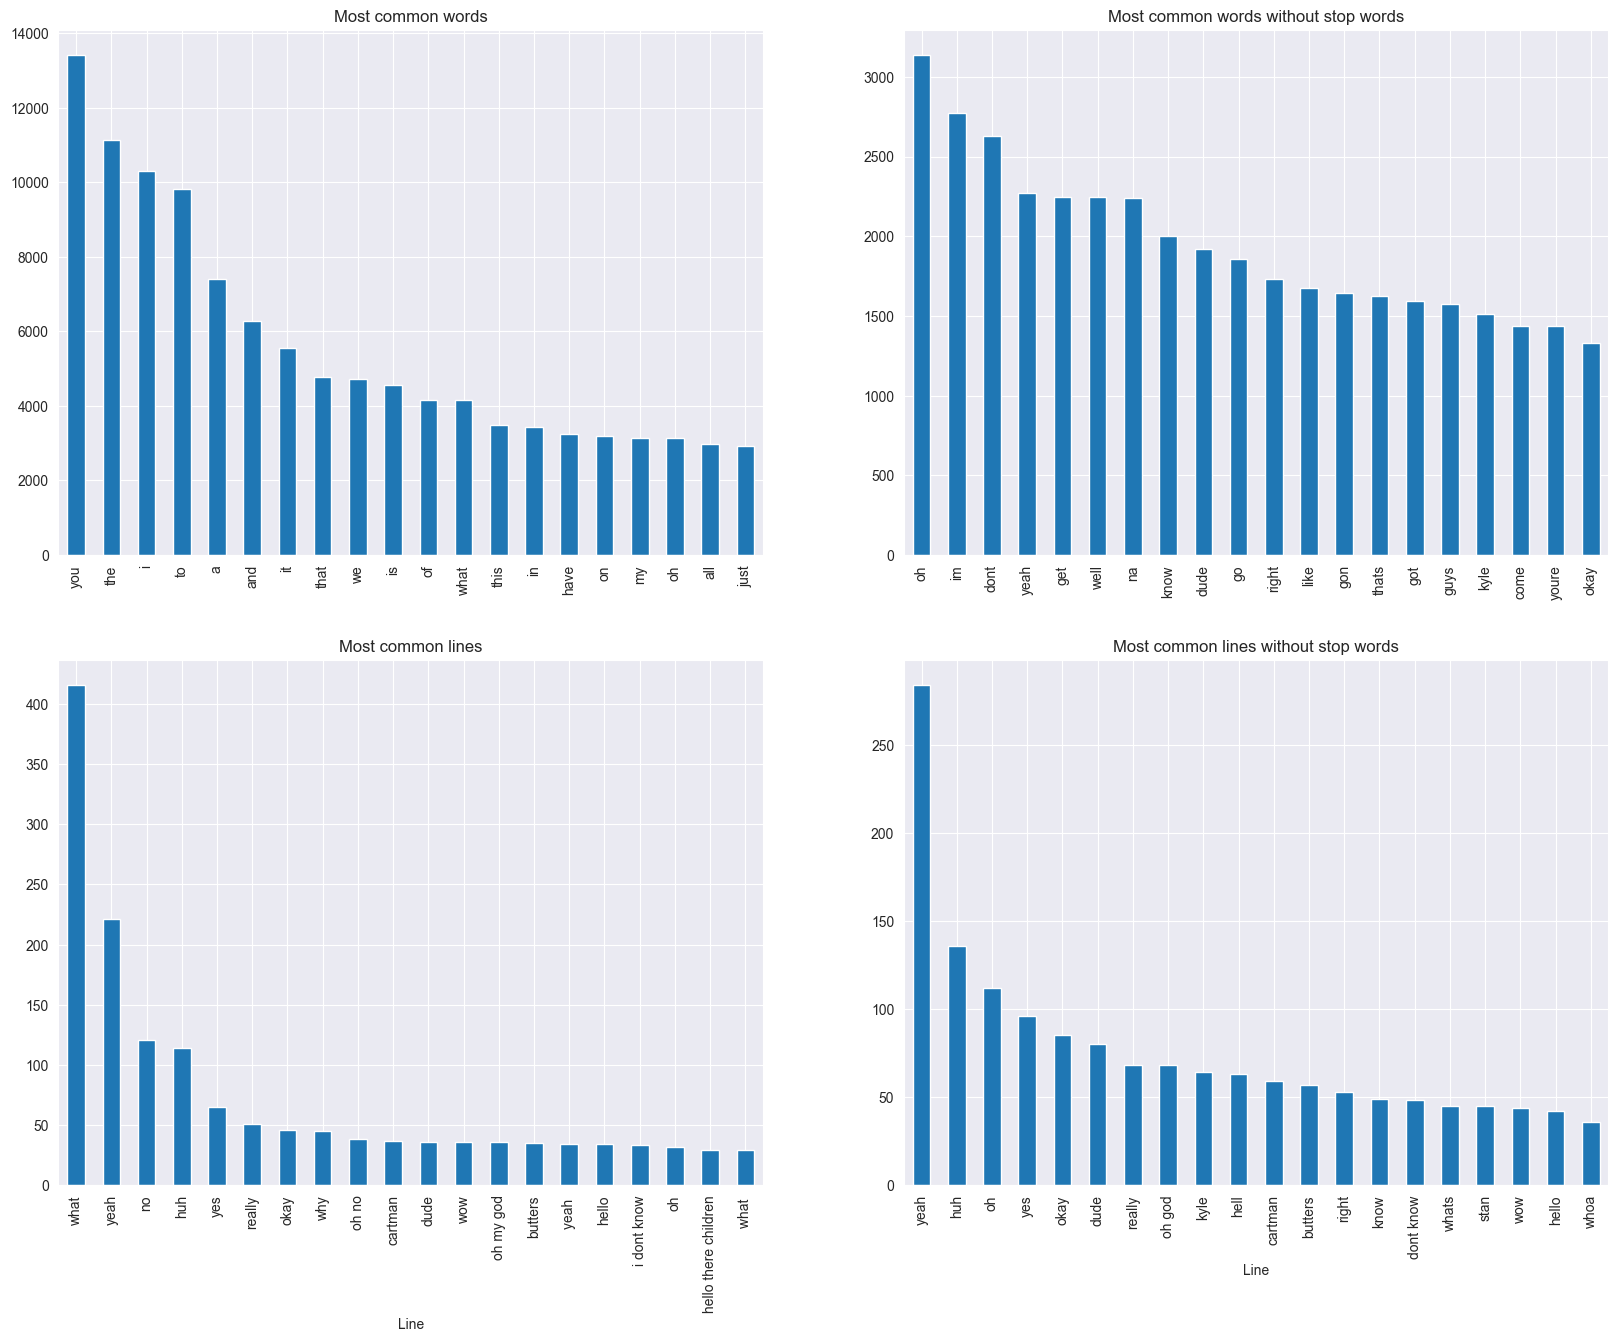

In [163]:
most_common_words = pd.Series(" ".join(df["Line"]).split()).value_counts()[:20]
most_common_words_no_stop = pd.Series(" ".join(df_no_stop["Line"]).split()).value_counts()[:20]
most_common_lines = df["Line"].value_counts()[:20]
most_common_lines_no_stop = df_no_stop["Line"].value_counts()[:20]

fig, axs = plt.subplots(2, 2, figsize=(20, 15))

most_common_words.plot(kind="bar", ax=axs[0, 0])
axs[0, 0].set_title("Most common words")

most_common_words_no_stop.plot(kind="bar", ax=axs[0, 1])
axs[0, 1].set_title("Most common words without stop words")

most_common_lines.plot(kind="bar", ax=axs[1, 0])
axs[1, 0].set_title("Most common lines")

most_common_lines_no_stop.plot(kind="bar", ax=axs[1, 1])
axs[1, 1].set_title("Most common lines without stop words")

plt.show()

The plot above shows the number of episodes in each season. The number of episodes in each season varies from 10 to 18.

The plot above shows the 20 most common words and lines in the dataset. The most common word is "oh" and the most common line is "yeah". 

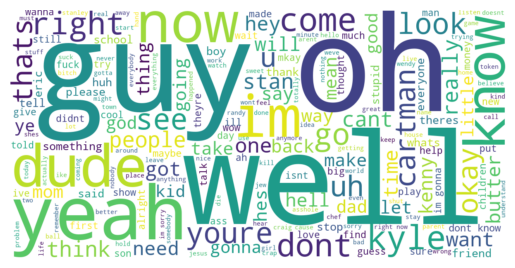

In [164]:
word_cloud = WordCloud(width=1200, height=600, background_color="white").generate(" ".join(df["Line"]))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")

plt.show()

The word cloud above highlights the various keywords present in the dataset. Larger words indicate more frequent occurrences, while smaller ones represent less common terms. This visualization helps identify dominant themes and trends within the data more precisely.

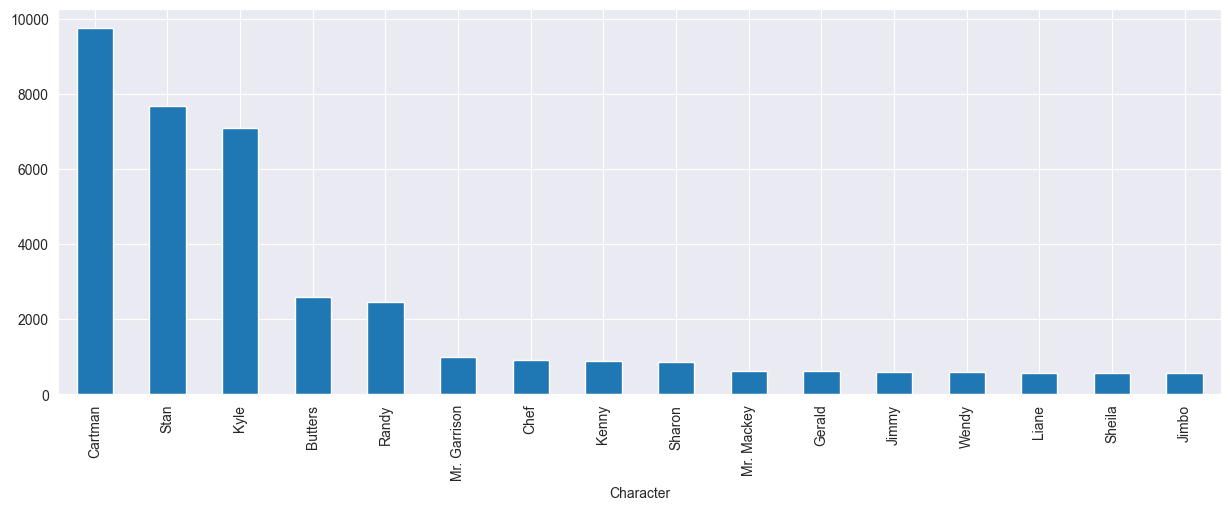

In [165]:
characters_count = df["Character"].value_counts()
least_common_characters = characters_count[characters_count == 10]
most_common_characters = characters_count[:20]

most_common_characters.plot(kind="bar", figsize=(15, 5))

plt.show()

The plot above shows the 20 most common characters in the dataset. The most common characters are "Cartman", "Stan" and "Kyle" as they are the main characters in show.

In [166]:
least_common_characters = characters_count[characters_count == 10]
least_common_characters

Series([], Name: count, dtype: int64)

The characters with the least dialogues are shown above. There are 62 characters with 10 dialogues which is the least that a character can have that are allowed in the dataset.

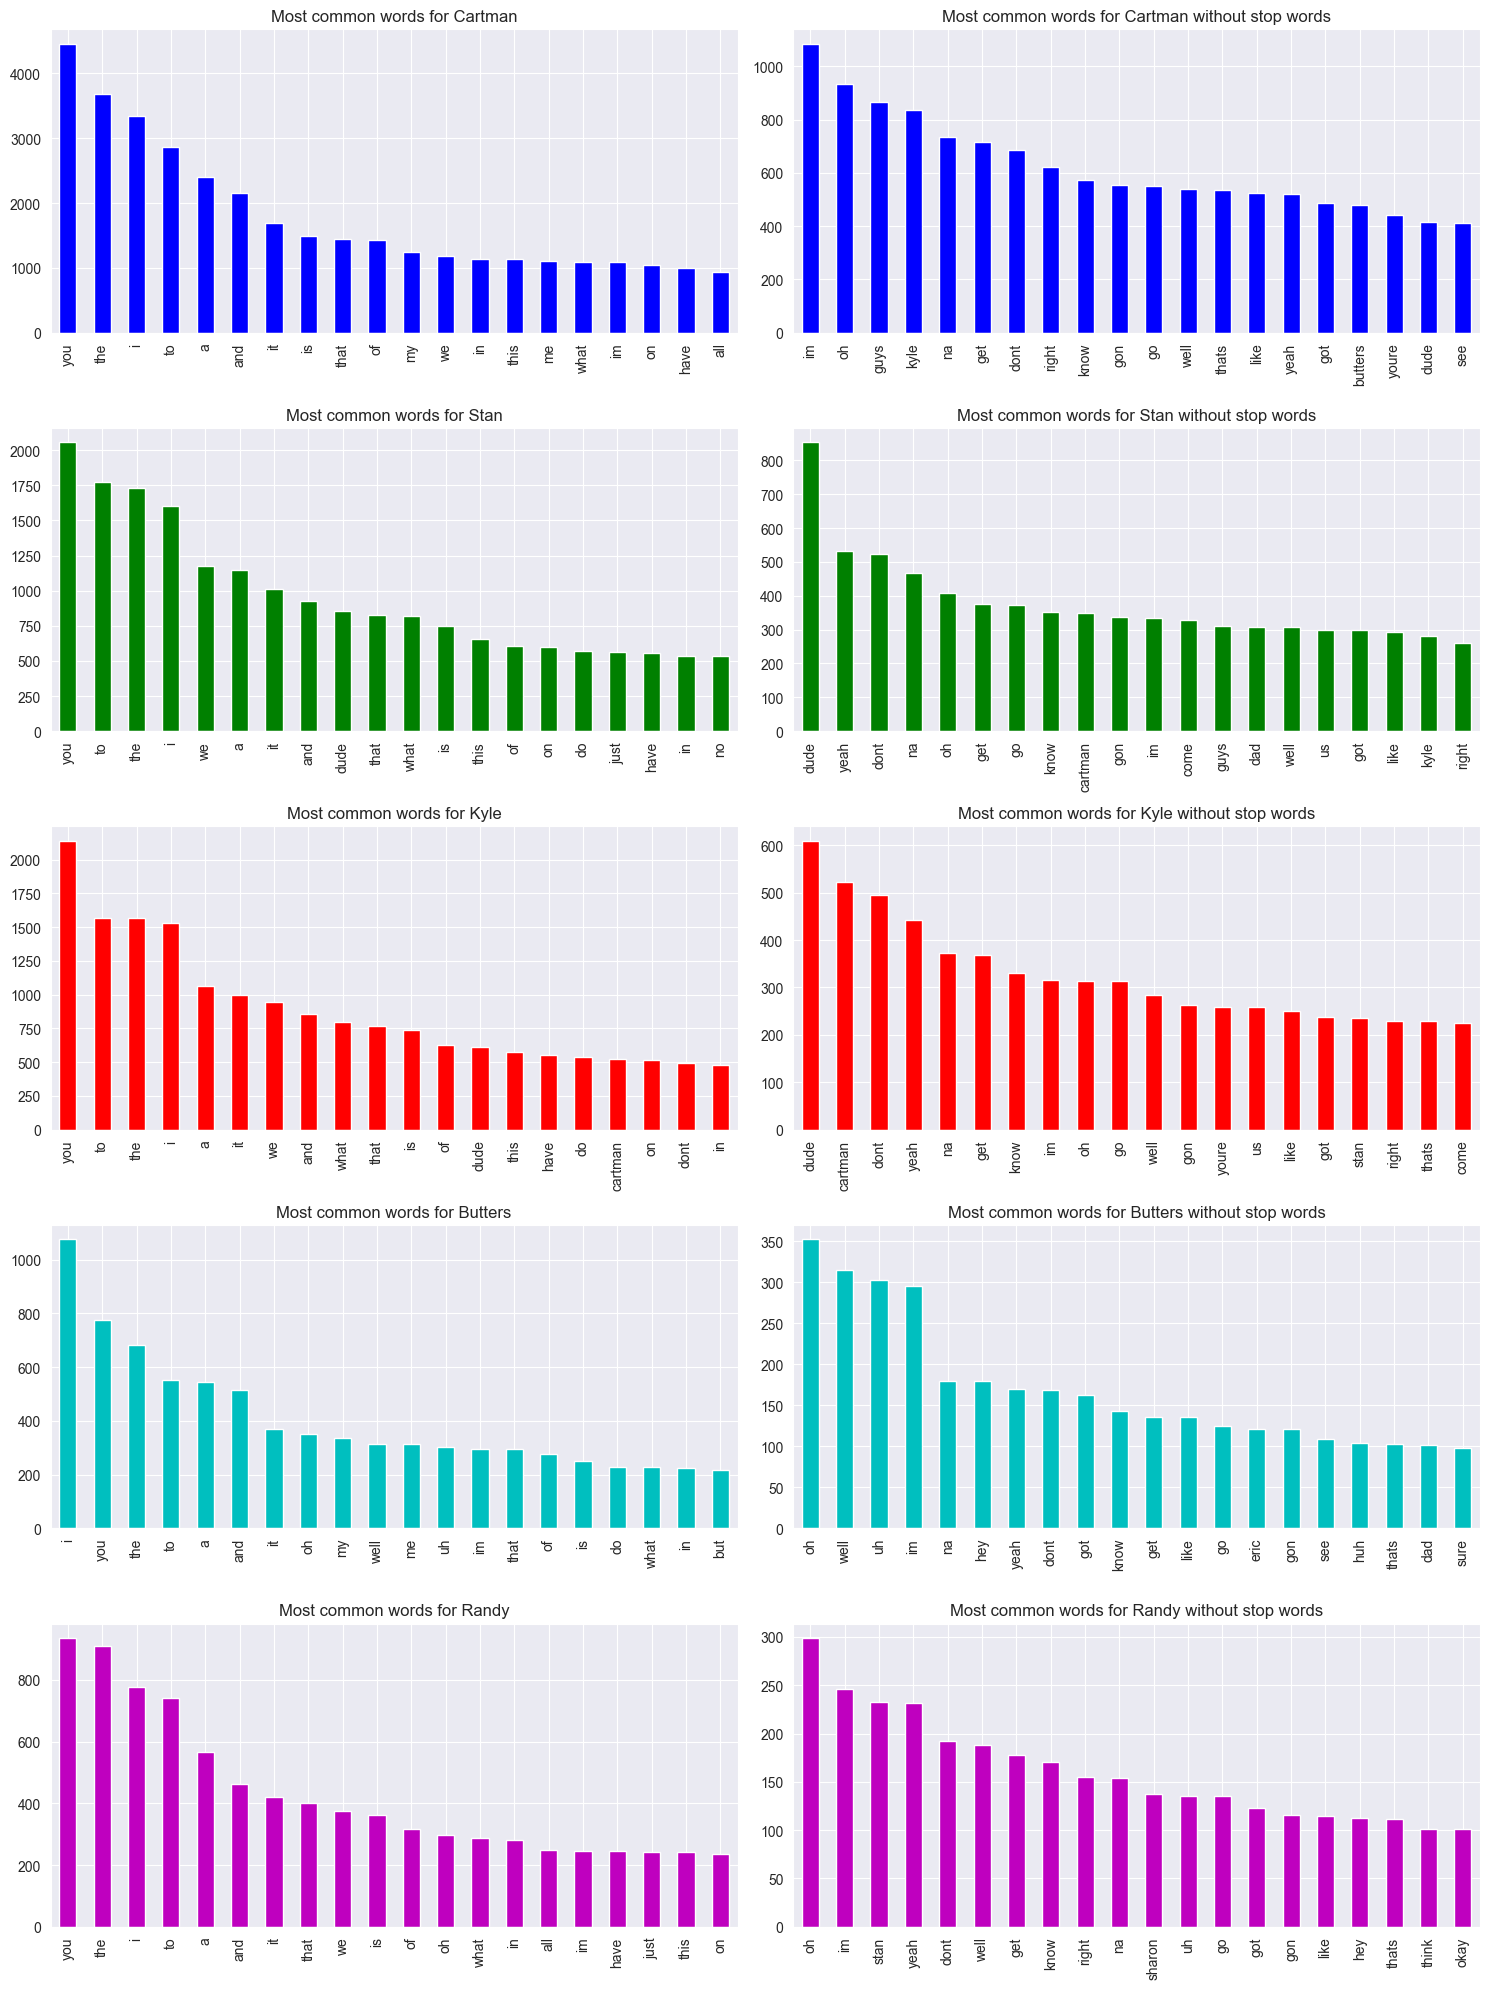

({'character': 'Cartman',
  'all_words': {'you': 4455,
   'the': 3678,
   'i': 3340,
   'to': 2871,
   'a': 2394,
   'and': 2149,
   'it': 1694,
   'is': 1486,
   'that': 1441,
   'of': 1425,
   'my': 1241,
   'we': 1188,
   'in': 1132,
   'this': 1130,
   'me': 1112,
   'what': 1097,
   'im': 1084,
   'on': 1037,
   'have': 996,
   'all': 940,
   'oh': 935,
   'guys': 867,
   'for': 846,
   'just': 844,
   'kyle': 834,
   'no': 800,
   'your': 747,
   'are': 746,
   'do': 734,
   'get': 714,
   'be': 713,
   'dont': 686,
   'its': 661,
   'so': 651,
   'with': 633,
   'right': 620,
   'not': 617,
   'now': 604,
   'know': 573,
   'can': 567,
   'out': 566,
   'gonna': 554,
   'go': 552,
   'but': 547,
   'well': 541,
   'thats': 537,
   'like': 523,
   'yeah': 522,
   'here': 510,
   'was': 510,
   'up': 491,
   'butters': 478,
   'youre': 440,
   'if': 426,
   'were': 423,
   'dude': 415,
   'see': 411,
   'about': 410,
   'come': 406,
   'at': 400,
   'how': 398,
   'okay': 382,
   

In [167]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']

words_per_character = []
words_no_stop_per_character = []

all_characters = characters_count.index

for character in all_characters:
    character_lines = df[df["Character"] == character]["Line"]
    character_lines_no_stop = df_no_stop[df_no_stop["Character"] == character]["Line"]
    all_words = pd.Series(" ".join(character_lines).split()).value_counts()
    all_words_no_stop = pd.Series(" ".join(character_lines_no_stop).split()).value_counts()

    words_per_character.append({
        "character": character,
        "all_words": all_words.to_dict()
    })
    words_no_stop_per_character.append({
        "character": character,
        "all_words_no_stop": all_words_no_stop.to_dict()
    })

most_common_characters = characters_count[:5].index
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, character in enumerate(most_common_characters):
    character_lines = df[df["Character"] == character]["Line"]
    character_lines_no_stop = df_no_stop[df_no_stop["Character"] == character]["Line"]
    most_common_words = pd.Series(" ".join(character_lines).split()).value_counts()[:20]
    most_common_words_no_stop = pd.Series(" ".join(character_lines_no_stop).split()).value_counts()[:20]

    most_common_words.plot(kind="bar", ax=axs[i, 0], color=colors[i % len(colors)])
    most_common_words_no_stop.plot(kind="bar", ax=axs[i, 1], color=colors[i % len(colors)])
    axs[i, 0].set_title(f"Most common words for {character}")
    axs[i, 1].set_title(f"Most common words for {character} without stop words")

plt.tight_layout()
plt.show()

words_per_character[0], words_no_stop_per_character[0]

The plot above shows the 20 most common words for the 5 most common characters in the dataset. The most common words for each character are different and unique to the character. We can see that there are many duplicate words in the dataset with stop words that are not useful in distinguishing the characters.

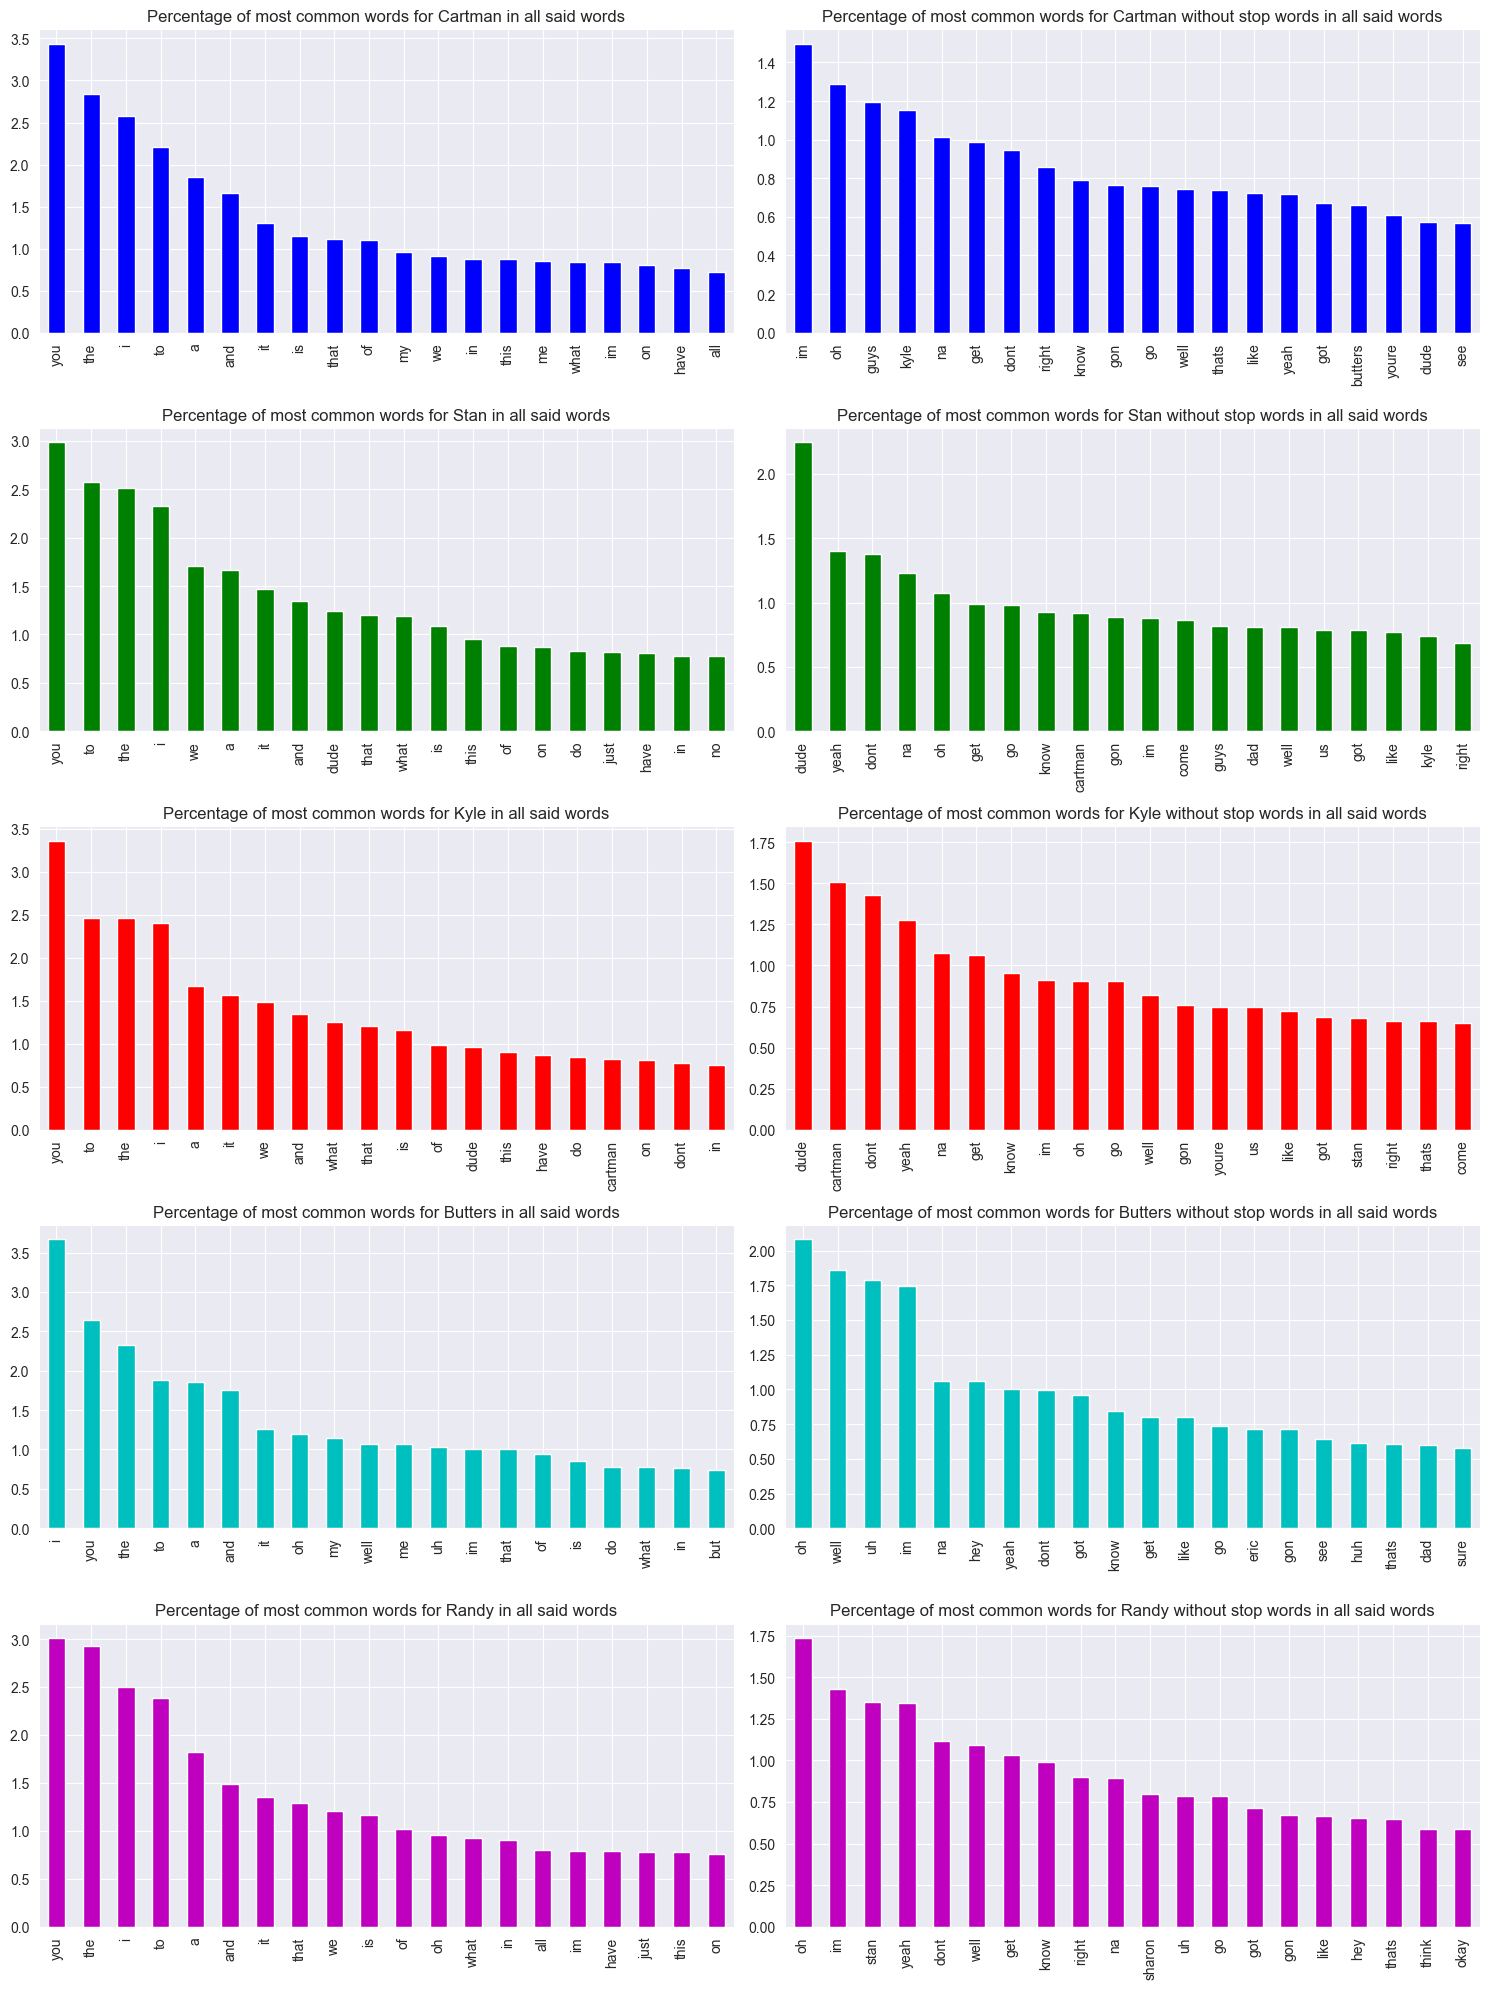

({'character': 'Cartman',
  'all_words': {'you': 3.435644327909308,
   'the': 2.836430940078661,
   'i': 2.5757692604303233,
   'to': 2.214081900208221,
   'a': 1.846225032775507,
   'and': 1.6572838744505283,
   'it': 1.3063931518469962,
   'is': 1.145985964371096,
   'that': 1.1112824863114057,
   'of': 1.0989434718901827,
   'my': 0.9570448060461171,
   'we': 0.9161718207758155,
   'in': 0.8729852703015347,
   'this': 0.8714428934988817,
   'me': 0.8575615022750057,
   'what': 0.8459936762551091,
   'im': 0.8359682270378653,
   'on': 0.7997223721755224,
   'have': 0.7681036477211383,
   'all': 0.7249170972468574,
   'oh': 0.7210611552402252,
   'guys': 0.668620343950027,
   'for': 0.6524253875221717,
   'just': 0.6508830107195188,
   'kyle': 0.6431711267062543,
   'no': 0.6169507210611552,
   'your': 0.5760777357908536,
   'are': 0.5753065473895272,
   'do': 0.56605228657361,
   'get': 0.5506285185470811,
   'be': 0.5498573301457546,
   'dont': 0.5290352433099406,
   'its': 0.509755

In [168]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']

words_per_character_percentage = []
words_no_stop_per_character_percentage = []

all_characters = characters_count.index

for character in all_characters:
    character_lines = df[df["Character"] == character]["Line"]
    character_lines_no_stop = df_no_stop[df_no_stop["Character"] == character]["Line"]
    total_words = len(" ".join(character_lines).split())
    total_words_no_stop = len(" ".join(character_lines_no_stop).split())

    all_words = pd.Series(" ".join(character_lines).split()).value_counts()
    all_words_no_stop = pd.Series(" ".join(character_lines_no_stop).split()).value_counts()

    all_words_percentage = all_words / total_words * 100
    all_words_no_stop_percentage = all_words_no_stop / total_words_no_stop * 100

    words_per_character_percentage.append({
        "character": character,
        "all_words": all_words_percentage.to_dict()
    })
    words_no_stop_per_character_percentage.append({
        "character": character,
        "all_words_no_stop": all_words_no_stop_percentage.to_dict()
    })

most_common_characters = characters_count[:5].index
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, character in enumerate(most_common_characters):
    character_lines = df[df["Character"] == character]["Line"]
    character_lines_no_stop = df_no_stop[df_no_stop["Character"] == character]["Line"]
    total_words = len(" ".join(character_lines).split())
    total_words_no_stop = len(" ".join(character_lines_no_stop).split())

    most_common_words = pd.Series(" ".join(character_lines).split()).value_counts()[:20]
    most_common_words_no_stop = pd.Series(" ".join(character_lines_no_stop).split()).value_counts()[:20]

    most_common_words_percentage = most_common_words / total_words * 100
    most_common_words_no_stop_percentage = most_common_words_no_stop / total_words_no_stop * 100

    most_common_words_percentage.plot(kind="bar", ax=axs[i, 0], color=colors[i % len(colors)])
    most_common_words_no_stop_percentage.plot(kind="bar", ax=axs[i, 1], color=colors[i % len(colors)])
    axs[i, 0].set_title(f"Percentage of most common words for {character} in all said words")
    axs[i, 1].set_title(f"Percentage of most common words for {character} without stop words in all said words")

plt.tight_layout()
plt.show()

words_per_character_percentage[0], words_no_stop_per_character_percentage[0]

## Simple Static model building

A dictionary of all words is  created. It contains information who said the word, how many times the word was said by the character, the percentage of the word in all words said by the character, how many times the word was said by the character without stop words, and the percentage of the word in all words said by the character without stop words.

In [169]:
words_to_characters = {}

for word in most_common_words.index:
    max_score = 0
    max_character = None
    max_count = 0
    max_percentage = 0
    max_count_no_stop = 0
    max_percentage_no_stop = 0

    for character_index, character in enumerate(all_characters):
        character_words = words_per_character[character_index]["all_words"]
        character_words_no_stop = words_no_stop_per_character[character_index]["all_words_no_stop"]
        character_words_percentage = words_per_character_percentage[character_index]["all_words"]
        character_words_no_stop_percentage = words_no_stop_per_character_percentage[character_index]["all_words_no_stop"]

        count = character_words.get(word, 0)
        count_no_stop = character_words_no_stop.get(word, 0)
        score = character_words_percentage.get(word, 0) * count

        if score > max_score:
            max_score = score
            max_character = character
            max_count = count
            max_percentage = character_words_percentage.get(word, 0)
            max_count_no_stop = count_no_stop
            max_percentage_no_stop = character_words_no_stop_percentage.get(word, 0)

    if max_character:
        words_to_characters[word] = {
            "character": max_character,
            "count": max_count,
            "percentage": max_percentage,
            "count_no_stop": max_count_no_stop,
            "percentage_no_stop": max_percentage_no_stop
        }

words_to_characters["oh"]

{'character': 'Cartman',
 'count': 935,
 'percentage': 0.7210611552402252,
 'count_no_stop': 935,
 'percentage_no_stop': 1.2907946325031752}

The map above shows the information about the word "oh" in the dataset. The most frequent character being "Cartman" with 935 times. The percentage of the word "oh" in all words said by "Cartman" is 0.72%.

In [170]:
def CharacterPredictorWithStopWords(dialogue):
    dialogue = dialogue.lower()
    dialogue = re.sub(r'[^\w\s]', '', dialogue)
    dialogue_words = [word for word in word_tokenize(dialogue) if word.lower() not in stopwords.words("english")]

    character_scores = {character: 0 for character in characters_count.index}

    for word in dialogue_words:
        if word in words_to_characters:
            character = words_to_characters[word]["character"]
            character_scores[character] += words_to_characters[word]["percentage"] * words_to_characters[word]["count"]

    predicted_character = max(character_scores, key=character_scores.get)
    return predicted_character

def CharacterPredictorWithoutStopWords(dialogue):
    dialogue = dialogue.lower()
    dialogue = re.sub(r'[^\w\s]', '', dialogue)
    dialogue_words = [word for word in word_tokenize(dialogue) if word.lower() not in stopwords.words("english")]

    character_scores = {character: 0 for character in characters_count.index}

    for word in dialogue_words:
        if word in words_to_characters:
            character = words_to_characters[word]["character"]
            character_scores[character] += words_to_characters[word]["percentage_no_stop"] * words_to_characters[word]["count_no_stop"]

    predicted_character = max(character_scores, key=character_scores.get)
    return predicted_character

The model predicts the character based on the dialogue by calculating the percentage of the most common words in the dialogue that are also present in the dialogues of each character multiplied by how many times each character said the word. The character with the highest percentage of compatibility is predicted as the character that said the dialogue. Calculations are done for both versions of the dataset - with and without stop words on the basis of dictionary created earlier.


In [171]:
print(CharacterPredictorWithStopWords("Dude, what the hell?"))
print(CharacterPredictorWithoutStopWords("Dude, what the hell?"))

Cartman
Cartman


### Testing and reliability of the model

In [172]:
correct_predictions_with_stop_words = 0
correct_predictions_without_stop_words = 0

for character in all_characters:
    character_lines = df[df["Character"] == character]["Line"]
    character_lines_no_stop = df_no_stop[df_no_stop["Character"] == character]["Line"]

    for line in character_lines:
        predicted_character = CharacterPredictorWithStopWords(line)
        if predicted_character == character:
            correct_predictions_with_stop_words += 1

    for line in character_lines_no_stop:
        predicted_character = CharacterPredictorWithoutStopWords(line)
        if predicted_character == character:
            correct_predictions_without_stop_words += 1

accuracy_with_stop_words = correct_predictions_with_stop_words / len(df) * 100
accuracy_without_stop_words = correct_predictions_without_stop_words / len(df_no_stop) * 100

accuracy_with_stop_words, accuracy_without_stop_words

(26.11344144914371, 26.405286587220395)

## More Advanced Approach: Multinomial Naive Bayes (MNB) Model and Logistic Regression

In this section, we use both **Multinomial Naive Bayes (MNB)** and **Logistic Regression** to predict the character speaking a given dialogue.

### Why Multinomial Naive Bayes?

Multinomial Naive Bayes is well-suited for text classification tasks, as it handles categorical data like word frequencies. It assumes that features (words) follow a multinomial distribution, aligning well with text data represented by word counts or term frequencies. We train and evaluate the model on two dataset variations:
- Including stop words.
- Excluding stop words.

This helps determine if stop words are useful or if removing them improves the model's performance.

### Why Logistic Regression?

Logistic Regression is a **linear model** that learns relationships between features and the target variable. Unlike Naive Bayes, it doesn't assume feature independence and can capture more complex patterns. We apply Logistic Regression to both variations of the dataset to compare its performance with Naive Bayes and assess the impact of stop-word removal on classification accuracy.


In [173]:
X = df["Line"]
y = df["Character"]

X_no_stop = df_no_stop["Line"]
y_no_stop = df_no_stop["Character"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_no_stop, X_test_no_stop, y_train_no_stop, y_test_no_stop = train_test_split(X_no_stop, y_no_stop, test_size=0.2, random_state=42)

print(f"X_train example: \n{X_train.head(5)}\n")
print(f"X_test example: \n{X_test.head(5)}")

X_train example: 
64889    aw jeez jeez louise my mom is gonna be awful s...
2553                          biggie smalls biggie smalls 
55145        uh well yeah youve all done it more than once
61965                   im going to kill you one day token
7441                                                yeahhh
Name: Line, dtype: object

X_test example: 
70139                                         yeah see ya 
31920    wait wait  who is that  chief could you excuse...
32432                                   its a power outage
37385                        hello everyone happy holidays
54020    doctor can you tell me exactly how stem cells ...
Name: Line, dtype: object


The dataset is split into training and testing sets. The "Line" column is the feature and the "Character" column is the target. The dataset is split into two variants: one with stop words and one without stop words.

In [174]:
cv = CountVectorizer()
tfidf = TfidfTransformer()
normalizer = Normalizer()

Xtr_bow = cv.fit_transform(X_train)
Xte_bow = cv.transform(X_test)    

X_train = tfidf.fit_transform(Xtr_bow) 
X_test = tfidf.transform(Xte_bow)      

X_train = normalizer.fit_transform(X_train) 
X_test = normalizer.transform(X_test)

Xtr_bow_no_stop = cv.fit_transform(X_train_no_stop)
Xte_bow_no_stop = cv.transform(X_test_no_stop)

X_train_no_stop = tfidf.fit_transform(Xtr_bow_no_stop)
X_test_no_stop = tfidf.transform(Xte_bow_no_stop)

X_train_no_stop = normalizer.fit_transform(X_train_no_stop)
X_test_no_stop = normalizer.transform(X_test_no_stop)

The training data is first converted into a matrix of word counts using the CountVectorizer. Then, the matrix is transformed into a normalized representation of term frequencies or term-frequency inverse document frequencies using the TfidfTransformer. Finally, the data is normalized with the Normalizer.

In [175]:
MultinomialNB_model = MultinomialNB()
MultinomialNB_model.fit(X_train, y_train)

score = MultinomialNB_model.score(X_test, y_test)

print(f"Multinomial Naive Bayes score: {score}")

Multinomial Naive Bayes score: 0.33756345177664976


In [176]:
MultinomialNB_model_no_stop = MultinomialNB()
MultinomialNB_model_no_stop.fit(X_train_no_stop, y_train_no_stop)

score_no_stop = MultinomialNB_model_no_stop.score(X_test_no_stop, y_test_no_stop)

print(f"Multinomial Naive Bayes score without stop words: {score_no_stop}")

Multinomial Naive Bayes score without stop words: 0.3403372961017418


The Multinomial Naive Bayes model is trained on the original data and achieves an accuracy of 0.3366. After removing stop words, the accuracy slightly improves to 0.34034. While removing stop words helps marginally, the low accuracy suggests that the model struggles to capture the nuances of the dialogues.

This is likely due to the Naive Bayes assumption of feature independence, which doesn't account for the contextual relationships between words in dialogues. Additionally, CountVectorizer and TF-IDF focus on word frequency, ignoring word semantics and context. These limitations prevent the model from fully understanding the complexity of language, particularly in dialogue-based datasets.

In [177]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

lr_score = lr.score(X_test, y_test)
print("Logistic Regression score:", lr_score)

Logistic Regression score: 0.39366818060379377


In [178]:
lr_no_stop = LogisticRegression(max_iter=1000, random_state=42)
lr_no_stop.fit(X_train_no_stop, y_train_no_stop)

lr_score_no_stop = lr_no_stop.score(X_test_no_stop, y_test_no_stop)

print("Logistic Regression no stop words score:", lr_score_no_stop)

Logistic Regression no stop words score: 0.3936964335084324


The Logistic Regression model is trained on the dataset with stop words, achieving an accuracy of 0.39366. When stop words are removed, the accuracy slightly increases to 0.39369. The minimal change suggests that removing stop words does not significantly impact the model's performance.

This could be attributed to the fact that Logistic Regression is a linear model, which might not be well-suited for capturing the complexities and interactions inherent in language, particularly in dialogue.

## Conclusions

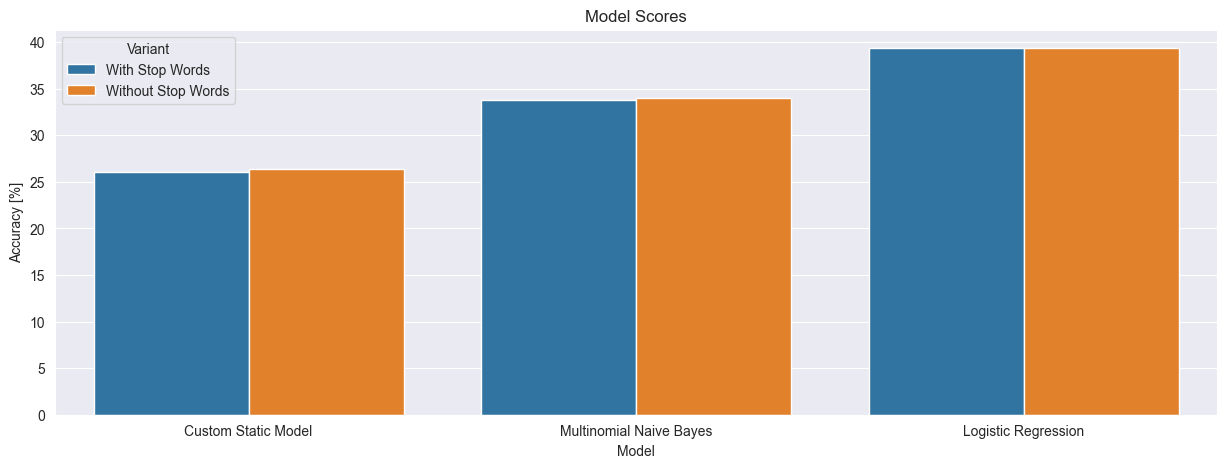

In [192]:
scores = [accuracy_with_stop_words, accuracy_without_stop_words, score*100, score_no_stop*100, lr_score*100, lr_score_no_stop*100]
models = ["Custom Static Model", "Custom Static Model", "Multinomial Naive Bayes", "Multinomial Naive Bayes", "Logistic Regression", "Logistic Regression"]
variants = ["With Stop Words", "Without Stop Words"] * 3

data = pd.DataFrame({
    "Model": models,
    "Variant": variants,
    "Accuracy": scores
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="Model", y="Accuracy", hue="Variant", data=data, ax=ax)
ax.set_title("Model Scores")
ax.set_ylabel("Accuracy [%]")

plt.show()

After conducting experiments with different classification models, the results reveal varying levels of effectiveness in predicting the speaker of a given dialogue.

1. **Custom Static Model**:
   - A custom, static model was developed for this task. The model creates a dictionary containing information about each word, such as which character said it, how many times the word was said, the percentage of the word in all words spoken by the character, how many times the word was said without stop words, and the percentage of the word in all words said by the character without stop words. This model achieved an accuracy of **26.11344 with stop words** and **26.40529 without stop words**. While these results are lower than those from the other models, they suggest that removing stop words can have a slight effect on performance, potentially by reducing the influence of less informative words.

2. **Multinomial Naive Bayes (MNB)**:
   - The model achieved an accuracy of 0.3366 with stop words included, and improved slightly to 0.34034 after stop words were removed. The minor improvement suggests that removing stop words helps reduce noise, but the model's overall performance remains relatively low. This is due to the **independence assumption** of features, which doesn't always hold in natural language, where words have strong semantic dependencies.

3. **Logistic Regression**:
   - The model achieved an accuracy of 0.39366 with stop words and 0.39369 after removing stop words. The minimal change suggests that stop word removal has little impact on the model's performance. Logistic Regression is a **linear model**, and while it can capture more complex patterns than Naive Bayes, it still struggles to fully capture the nuances of natural language, particularly in dialogue-based datasets.

Overall, while the **Multinomial Naive Bayes** and **Logistic Regression** models show limited improvements with stop word removal, they still struggle to capture the full complexity of dialogues. The **custom static model** offers an interesting approach based on word usage statistics but requires further refinement to compete with more advanced techniques.